# 赛题介绍

- 赛题名称：Detect AI Generated Text
- 赛题类型：文本分类、自然语言处理
- 赛题任务：识别哪篇文章是由大型语言模型撰写的
- 赛题链接：https://www.kaggle.com/competitions/llm-detect-ai-generated-text/


赛题涉及建立一个模型来区分中学和高中学生所写的文章与由大型语言模型（LLM）所写的文章。由于LLMs的广泛使用，很多人担心它们将取代或改变通常由人类完成的工作。教育工作者特别担心它们对学生技能发展的影响，尽管很多人对LLMs最终成为帮助学生提高写作技能的有用工具持乐观态度。

在学术界对LLMs的主要担忧之一是它们可能助长抄袭行为。LLMs是在大规模文本和代码数据集上训练的，这意味着它们能够生成与人类写作非常相似的文本。

# 赛题任务

参赛选手在这个竞赛中的工作可以帮助识别LLM的痕迹，并推动LLM文本检测的技术。

# 赛题数据

竞赛数据集包含大约10,000篇文章，其中一部分由学生撰写，一部分由各种大型语言模型（LLMs）生成。竞赛的目标是确定一篇文章是否由LLM生成。

所有的文章都是作为对七个不同的作文题目之一的回应而写的。在每个题目中，学生被要求阅读一个或多个源文本，然后写出回应。这些信息可能会或者不会作为LLM生成文章的输入。

两个题目的作文构成了训练集，其余的作文构成了隐藏的测试集。几乎所有的训练集作文都是由学生写的，只有少数生成的作文作为示例。您可以考虑生成更多的作文来用作训练数据。

**文件和字段信息**：

-   {test/train}_essays.csv
    -   `id` - 每篇文章的唯一标识符。
    -   `prompt_id` - 识别文章是回应哪个作文题目写的。
    -   `text` - 文章正文。
    -   `generated` - 文章是由学生写的 (`0`) 还是由LLM生成的 (`1`)。这个字段是目标变量，在`test_essays.csv`中不包括。

-   train_prompts.csv
    -   `prompt_id` - 每个作文题目的唯一标识符。
    -   `prompt_name` - 作文题目的标题。
    -   `instructions` - 给学生的指示。
    -   `source_text` - 文章或文章的文本，这些文章是学生在回应中编写的，采用Markdown格式。

-   sample_submission.csv - 一个格式正确的提交文件。

# 评价指标

提交的内容根据预测概率与观察目标之间的 ROC 曲线下面积进行评估。

对于测试集中的每个 id，您必须预测生成该文章的概率。该文件应包含标头并具有以下格式：

```
id,generated
0000aaaa,0.1
1111bbbb,0.9
2222cccc,0.4
...
```

# 解题思路

- 基于训练的分类器（Training-based）：通常是在已收集的二进制数据上对预训练语言模型进行微调，这些数据包括人类生成和AI生成的文本分布。
- 零-shot检测器（Zero-Shot）：利用典型LLM的内在特性，如概率曲线或表示空间，进行自我检测。
- 水印技术（Watermarking）：涉及将可识别信息隐藏在生成的文本中，以后可以用于确定文本是否来自特定的语言模型，而不仅仅是检测AI生成的文本。

# 导入环境

In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import itertools

DATA_PATH = './input'

train_essays = pd.read_csv(f'{DATA_PATH}/train_essays.csv')
train_prompts = pd.read_csv(f'{DATA_PATH}/train_prompts.csv')
test_essays = pd.read_csv(f'{DATA_PATH}/test_essays.csv')
sample_submit = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')

In [32]:
train_essays.shape, train_prompts.shape, test_essays.shape

((1378, 4), (2, 4), (3, 3))

# 数据分析

https://www.kaggle.com/code/pamin2222/ai-or-not-ai-delving-into-essays-with-eda

In [33]:
train_essays.head(1)

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0


In [34]:
train_prompts.head(1)

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."


In [35]:
test_essays.head(1)

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.


In [36]:
train_essays = pd.merge(train_prompts, train_essays, on='prompt_id', how='right')
train_essays.head(1)

,prompt_id,prompt_name,instructions,source_text,id,text,generated
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0059830c,Cars. Cars have been around since they became ...,0


In [37]:
test_essays = pd.merge(train_prompts, test_essays, on='prompt_id', how='right')
test_essays.head(1)

,prompt_id,prompt_name,instructions,source_text,id,text
0,2,NaN,NaN,NaN,0000aaaa,Aaa bbb ccc.


In [38]:
train_essays['generated'].value_counts()

0    1375
1       3
Name: generated, dtype: int64

In [39]:
train_essays['generated']

0       0
1       0
2       0
3       0
4       0
       ..
1373    0
1374    0
1375    0
1376    0
1377    0
Name: generated, Length: 1378, dtype: int64

## Distribution of Essay Lengths

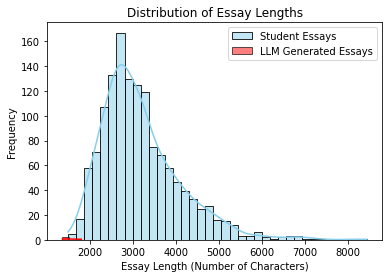

In [40]:
# Calculate the length of each essay and create a new column
train_essays['essay_length'] = train_essays['text'].apply(len)

# Distribution of essay lengths for student essays
sns.histplot(train_essays[train_essays['generated'] == 0]['essay_length'], color="skyblue", label='Student Essays', kde=True)

# Distribution of essay lengths for LLM generated essays
sns.histplot(train_essays[train_essays['generated'] == 1]['essay_length'], color="red", label='LLM Generated Essays', kde=True)

plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length (Number of Characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Comparison of Essay Lengths by Source

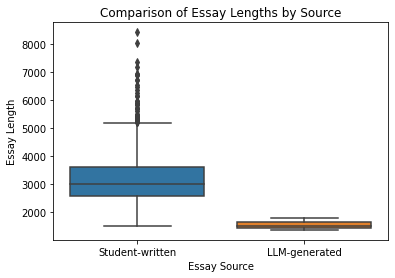

In [41]:
sns.boxplot(x='generated', y='essay_length', data=train_essays)
plt.title('Comparison of Essay Lengths by Source')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Student-written', 'LLM-generated'])
plt.show()

In [45]:
def calculate_text_metrics_simple(text):
    words = text.split()
    sentences = text.split('.')
    word_count = len(words)
    unique_word_count = len(set(words))
    sentence_count = len(sentences)
    avg_word_length = sum(len(word) for word in words) / word_count if word_count > 0 else 0
    return word_count, unique_word_count, sentence_count, avg_word_length


# Apply the function to the 'text' column
train_essays['metrics'] = train_essays['text'].apply(calculate_text_metrics_simple)

# Expand the 'metrics' column into separate columns
train_essays[
    ['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']
] = pd.DataFrame(train_essays['metrics'].tolist(), index=train_essays.index)
# Drop the 'metrics' column as it's no longer needed
train_essays.drop('metrics', axis=1, inplace=True)

# Group by 'generated' to compare these metrics between student-written and LLM-generated essays
comparison_metrics = train_essays.groupby('generated')[
    ['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']
].mean()
comparison_metrics

,word_count,unique_word_count,sentence_count,avg_word_length
generated,,,,
0,556.768727,275.334545,30.063273,4.694868
1,260.666667,146.333333,13.000000,4.935610


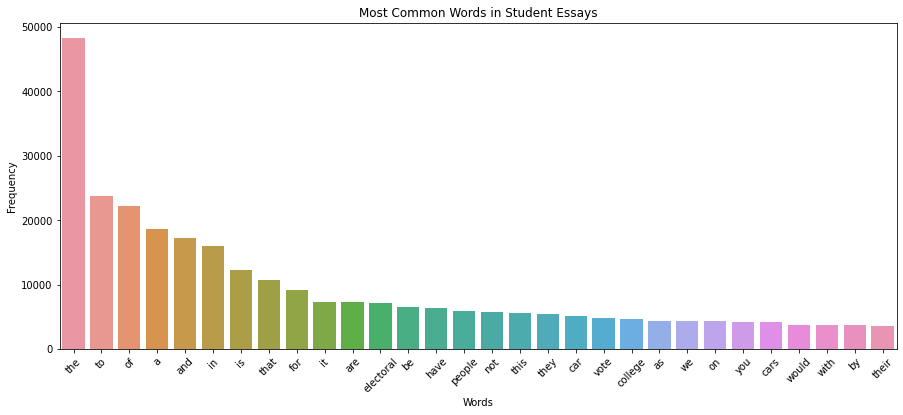

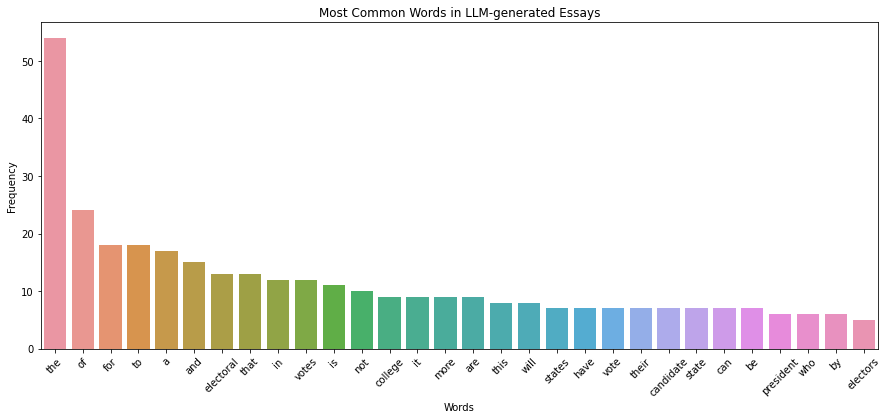

In [48]:
def plot_most_common_words(text_series, num_words=30, title="Most Common Words"):
    all_text = ' '.join(text_series).lower()
    words = all_text.split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(num_words)

    # Plot the most common words
    plt.figure(figsize=(15, 6))
    sns.barplot(x=[word for word, freq in common_words], y=[freq for word, freq in common_words])
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()


plot_most_common_words(train_essays[train_essays['generated'] == 0]['text'], title="Most Common Words in Student Essays")
plot_most_common_words(train_essays[train_essays['generated'] == 1]['text'], title="Most Common Words in LLM-generated Essays")

# 建模过程

## XGBoost人工特征

https://www.kaggle.com/code/tivfrvqhs5/20-feature-xgboost

```python
def mean_diff_in_sentence_length_per_paragraph(text):
    paragraphs = text.split('\n\n')
    
    mean_diffs = []
    for paragraph in paragraphs:
        sentences = re.split(r'[.?!]+', paragraph)
        sentence_lengths = [len(sentence.split()) for sentence in sentences if sentence.strip()]
        differences = [abs(sentence_lengths[i] - sentence_lengths[i+1]) for i in range(len(sentence_lengths) - 1)]
        
        if differences:
            mean_diff = statistics.mean(differences)
        else:
            mean_diff = 0  # handle where no consecutive sentences or only empty sentences are present
        mean_diffs.append(mean_diff)
    
    return mean_diffs

def detect_word_alhough(text):
    paragraphs = text.split('\n\n')
    presence = [1 if 'although' in paragraph.lower() else 0 for paragraph in paragraphs]
    return presence

```

## DeBERTa文本分类

https://www.kaggle.com/code/alejopaullier/daigt-deberta-text-classification-train

https://www.kaggle.com/code/alejopaullier/daigt-deberta-text-classification-inference

```python
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings
    
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.dropout = 0.2
        # Load config by inferencing it from the model name.
        if config_path is None: 
            self.config = AutoConfig.from_pretrained(cfg.MODEL, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
        # Load config from a file.
        else:
            self.config = torch.load(config_path)
        
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.MODEL, config=self.config)
        else:
            self.model = AutoModel(self.config)
        
        if self.cfg.GRADIENT_CHECKPOINTING:
            self.model.gradient_checkpointing_enable()
          
        # Add MeanPooling and Linear head at the end to transform the Model into a RegressionModel
        self.pool = MeanPooling()
        self.head = nn.Sequential(
            nn.Linear(self.config.hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(16, 1)
        )
        self._init_weights(self.head)
        
    def feature(self, inputs):
        """
        This method makes a forward pass through the model, get the last hidden state (embedding)
        and pass it through the MeanPooling layer.
        """
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        """
        This method makes a forward pass through the model, the MeanPooling layer and finally
        then through the Linear layer to get a regression value.
        """
        feature = self.feature(inputs)
        output = self.head(feature)
        return output
```

## Tokenizer + TFIDF

https://www.kaggle.com/code/verracodeguacas/sentencepiece-constructions

https://www.kaggle.com/code/hubert101/0-960-phrases-are-keys/


In [57]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from datasets import Dataset
from transformers import PreTrainedTokenizerFast

In [58]:
# train_v2_drcat_02_path = '/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv'
train_v2_drcat_02_path = './train_v2_drcat_02.csv'
train = pd.read_csv(train_v2_drcat_02_path, sep=',')

In [59]:
train.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [60]:
train = train.drop_duplicates(subset=['text'])
train.reset_index(drop=True, inplace=True)

In [66]:
LOWERCASE = False
VOCAB_SIZE = 30522

# Creating Byte-Pair Encoding tokenizer
raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))

# Adding normalization and pre_tokenizer
raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()

# Adding special tokens and creating trainer instance
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

# Creating huggingface dataset object
dataset = Dataset.from_pandas(test_essays[['text']])

def train_corp_iter():
    for i in range(0, len(dataset), 1000):
        yield dataset[i: i + 1000]["text"]
        
raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)
tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)
tokenized_texts_test = []

for text in test_essays['text'].tolist():
    tokenized_texts_test.append(tokenizer.tokenize(text))

tokenized_texts_train = []

for text in train['text'].tolist():
    tokenized_texts_train.append(tokenizer.tokenize(text))

In [70]:
vectorizer = TfidfVectorizer(
    ngram_range=(3, 5),
    lowercase=False,
    sublinear_tf=True,
    analyzer='word',
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    strip_accents='unicode'
)
vectorizer.fit(tokenized_texts_test)
vocab = vectorizer.vocabulary_

vectorizer = TfidfVectorizer(
    ngram_range=(3, 5), 
    lowercase=False, 
    sublinear_tf=True, 
    vocabulary=vocab,
    analyzer='word',
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None, 
    strip_accents='unicode'
)

tf_train = vectorizer.fit_transform(tokenized_texts_train)
tf_test = vectorizer.transform(tokenized_texts_test)

del vectorizer

In [72]:
y_train = train['label'].values

def get_model():
    from catboost import CatBoostClassifier
    clf = MultinomialNB(alpha=0.02)
    sgd_model = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber") 
    p6 = {
        'n_iter': 1500,
        'verbose': -1,
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05073909898961407,
        'colsample_bytree': 0.726023996436955,
        'colsample_bynode': 0.5803681307354022,
        'lambda_l1': 8.562963348932286,
        'lambda_l2': 4.893256185259296,
        'min_data_in_leaf': 115,
        'max_depth': 23,
        'max_bin': 898
    }
    lgb = LGBMClassifier(**p6)
    cat = CatBoostClassifier(
        iterations=1000,
        verbose=0,
        l2_leaf_reg=6.6591278779517808,
        learning_rate=0.005689066836106983/2,
        allow_const_label=True,
        loss_function = 'CrossEntropy',
        random_seed=1234
    )
    weights = [0.07,0.41,0.41,0.41]
 
    ensemble = VotingClassifier(
        estimators=[
            ('mnb',clf),
            ('sgd', sgd_model),
            ('lgb',lgb), 
            ('cat', cat)
        ],
        weights=weights, voting='soft', n_jobs=-1
    )
    return ensemble

model = get_model()
print(model)

if len(test_essays.text.values) <= 5:
    sample_submit.to_csv('submission.csv', index=False)
else:
    model.fit(tf_train, y_train)
    gc.collect()
    final_preds = model.predict_proba(tf_test)[:,1]
    sub['generated'] = final_preds
    sub.to_csv('submission.csv', index=False)
    sub

VotingClassifier(estimators=[('mnb', MultinomialNB(alpha=0.02)),
                             ('sgd',
                              SGDClassifier(loss='modified_huber',
                                            max_iter=8000, tol=0.0001)),
                             ('lgb',
                              LGBMClassifier(colsample_bynode=0.5803681307354022,
                                             colsample_bytree=0.726023996436955,
                                             lambda_l1=8.562963348932286,
                                             lambda_l2=4.893256185259296,
                                             learning_rate=0.05073909898961407,
                                             max_bin=898, max_depth=23,
                                             metric='auc', min_data_in_leaf=115,
                                             n_iter=1500, objective='binary',
                                             verbose=-1)),
                             ('cat',
   